# Introduction
This notebook is intended to demonstrate some simple applications of MCMC in astronomy using python, and will also set out some problems for attendees to solve. Please bear in mind that that these examples and problems all implicitly or explicitly assume Bayesian approaches, so I recommend you remind yourselves of the basic principles first.

The text and graphical elements of this work are licensed under Attribution 4.0 International. To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/. The code elements of this notebook are licensed under the MIT license (text at end).

# Some resources
You can find the slides for the lectures here. In addition to the slides, here is a reminder of some general resources that will be useful:


*   David Hogg's "lecture notes"
    * [Fitting a model to data](https://arxiv.org/abs/1008.4686)
    * [Probability calculus for inference](https://arxiv.org/abs/1205.4446)
    * [Using Markov Chain Monte Carlo](https://arxiv.org/abs/1710.06068)
    * [Products of multivariate Gaussians in Bayesian inferences](https://arxiv.org/abs/2005.14199)
*   [*emcee* tutorials](https://emcee.readthedocs.io/en/stable/tutorials/line/)
*   [The MCMC interactive gallery](https://chi-feng.github.io/mcmc-demo/app.html) is a great way to visualise how various MCMC implementations explore parameter space
* A [list of python MCMC packages](https://github.com/Gabriel-p/pythonMCMC)
* Johannes Buchner's [minimal statistics checklist and learning material](https://astrost.at/istics/minimal-statistics-checklist.html)
* Andrae et al (2010) a and b - discussing Error Estimation (key for defining Credible Intervals) and how *not* to use chi-squared statistics.


# This problem set
This will cover a number of examples, including
1.   Basics of Colab
2.   Why MCMC?
3.   Some MCMC implementations in python
4.   Interpreting the output of MCMC

It will then go on to describe a set of problems with differing levels of difficulty and work to do.  These include
1.   Fitting a line to data:
     1.   with underestimated uncertainties;
     2.   with uncertainties on both dependent and independent variabiles;
     3.   with intrinsic scatter;
     4.   in higher dimensions;
     5.   with non-Gaussian likelihoods;
2.   Checking convergence
3.   Posterior predictive checks
4.   Nuisance parameters
5.   Prior sensitivity

For the most part, these problems are setup in *emcee* but you are encouraged to try out other python packages based on other MCMC approaches.








# A quick reminder on Colab

Colab is a very convenient, free cloud service from Google which allows you to run Jupyter notebooks with limited compute resources. Notebooks let you combine code and text. This is a text cell, and the following is a code cell that shows how to do a few simple but important python calls, including importing and installing packages.

In [ ]:
import numpy as np #numpy is installed by default
#But you can also install packages that you need using pip
!pip install emcee
import emcee
#And if you want, you can create a try:...except:... to only attempt the install if absolutely necessary
try:
  import dynesty
except ImportError:
  !pip install dynesty
  import dynesty

#then it works just like python
a = 1
print(a)
b = np.arange(10)
c = a + b
print(c)

     |████████████████████████████████| 51kB 2.4MB/s 
     |████████████████████████████████| 92kB 4.3MB/s 
1
[ 1  2  3  4  5  6  7  8  9 10]


# Why MCMC?
When we derive quantities from data or models we are interested not just in a value, but in some understanding of the probability distributions of the quantity. Often, this is parametrised as a value and an uncertainty to describe a *credible region*, but this is only a good description for independent, mono-modal, approximately-Gaussian distributions. 

However, in real astronomical applications these criteria are often violated. Model parameters are often correlated, and their distributions may not be Gaussian or mono-modal, or even analytically evaluable. In these cases, classical approaches will fail, but often *without telling us that*!




# Some examples of MCMC packages in python that are used in astronomy

There are broadly two classes of packages that exist in python. The first support "black box" likelihoods, i.e. you write a function that connects the (potentially physical) model that you want to use with the data, similar to scipy.minimise or MPFITFUN. The second consists of probabilistic programming languages, which are more difficult to specify the model for but support a wider range of more complex MCMC (and other inference) methods, such as Hamiltonian Monte Carlo.

## Black box methods
emcee is particularly popular - simple to use, but capable of handling a wide variety of problems, including those where you just plug in a function to the likelihood. 

dynesty

ultranest

## Probabilistic programming
PyMC3 is probably the most widely used. The third incarnation of the PyMC family provides a particular advantage by supporting theano and Tensorflow ML libraries. 

pyro-ppl targets similar approaches as PyMC3 but is part of the Torch ML ecosystem. It also supports a variety of approaches such as Variational Inference.

STAN - one of the methods of choice for complex models with large numbers of parameters. Look out for this one for Hierarchical Models.

JAGS?

## A quick example

Here we have an example of using emcee to compute a black box likelihood and do some MCMC on it. In this case, the data are some observations of cold dust, and the model is the modified blackbody function. The data are assumed to be drawn from Normal distributions, so that the likelihood function is the familiar Gaussian likelihood
$\log \mathcal{L} \propto -\frac{1}{2}\sum\limits_{i}^{} \frac{\left(y_{i,\mathrm{obs}} - y_{i,\mathrm{mod}}\right)^2}{\sigma_i^2} $ where constant terms have been dropped for brevity.





In [ ]:
#For starters, we define the model itself - the process by which we think the observed data might have been generated
try:
  from astropy import constants as const
except ImportError:
  !pip install astropy
  from astropy import constants as const
from astropy import units as u
from astropy.modeling import blackbody

import warnings
warnings.filterwarnings("ignore", message="BlackBody provides the same capabilities")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")

#Here's some data: These are observations of the flux of XXX from XXXXX
x = np.array([70., 160., 250., 350., 500., 450., 850.]) #Wavelengths in micron
y = np.array([0.06291731942186395, 0.4737297147415956, 
              0.6390202295454346, 0.6397258752453974, 
              0.5666783622052882, 0.5923100333782477, 
              0.4048189704746445])#np.array([10, 12, 9, 7, 4, 3, 1]) #Fluxes in Jy
yerr = np.array([0.010727567289237351, 0.07215265086492663, 
                 0.06050432065824665, 0.10415758267647844, 
                 0.052355096848173376, 0.21872154153894846, 
                 0.09148243225657898])#np.array([2, 2, 2, 2, 2, 2, 1]) #Uncertainties on the fluxes

normWave = 160. #wavelength (in micron) at which dust opacity is normalised
sigmaNormWave = 0.3 #opacity/mass-absorption coefficient of the dust at normWave
dist = 100*u.pc.to(u.m) #Distance to the star

def model(M, T, beta, lam):
  #convert lambda to nu
  freq = const.c.value / (lam*1e-6)

  bb = blackbody.blackbody_nu(freq,T).to(u.Jy / u.sr).value
  bb = bb / dist**2
  bb = bb * 10**(M)*const.M_sun.value * sigmaNormWave * ((lam / normWave)**beta)
  return bb


def lnprior(theta):
  #This is a flat prior - probability is uniform inside a given range, and zero outside
  if -10 < theta[0] < 10 and 3 < theta[1] < 100 and -3 < theta[2] < 3:
    return 0
  return -np.inf

def lnlike(theta, x, y, yerr):
  #This function calculates the likelihood P(D|M) for our model.
  M = theta[0]
  T = theta[1]
  beta = theta[2]
  flux = model(M, T, beta, x)
  return-0.5* np.sum((y - flux)**2 /yerr**2)

def lnprob(theta, x, y, yerr):
  lp = lnprior(theta)
  if lp == -np.inf:
    return lp
  return lp + lnlike(theta, x, y, yerr)

#Now we have a model, and we have defined our posterior, we can set up a sampler and get things moving.
ndim=3 #Three dimensions for this problem - M, T and beta
nwalkers=100 #emcee is an affine-invariant ensemble sampler. This means it uses several chains.
             # the number of walkers (=chains) must be even, and should be as large as possible (at least double ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

steps = 500
pos = [[0, 10, 0] + np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos,steps)

State([[-5.16339785 37.33419629  1.30695901]
 [-2.59961377 10.20297476 -1.61078975]
 [-4.85562756 31.2375576   1.04232869]
 [-5.19618779 38.17609234  1.38188902]
 [-4.75516442 28.20744235  0.86637797]
 [-4.91122822 31.20784083  1.04812571]
 [-4.97621644 33.71443972  1.09326967]
 [-4.98520043 32.70310625  1.22324525]
 [-5.1307929  36.33425289  1.39907956]
 [-4.90442512 32.10385824  0.96482624]
 [-4.83165923 30.18221974  0.98757174]
 [-4.95318285 32.7816455   1.04356108]
 [-4.78552167 29.30324997  0.93894581]
 [-4.79720241 28.80688499  1.00011709]
 [-4.94352922 32.85489599  1.05070104]
 [-4.77599211 29.22555272  0.81917693]
 [-5.01745728 34.26160544  1.20974486]
 [-4.77091734 29.47311595  0.90736114]
 [-4.95632047 32.97783559  1.20160557]
 [-1.99309869  8.63472997 -2.37813214]
 [-5.14893318 36.37371699  1.26516037]
 [-4.92891893 33.37851016  1.07960951]
 [-4.81746403 30.36758307  0.92480891]
 [-4.93413209 32.52421583  1.10468038]
 [-4.98451322 34.00533324  1.09399055]
 [-2.9583066  11.33

# Interpreting the output
MCMC gives us *samples* from the posterior PDF of the model parameters. These samples are generated in *chains* such that consecutive points may be correlated. Therefore, the first thing to check is whether the chains are long enough to give enough independent samples from the distribution. 

One way of visualising this is the *trace* of the chains. The chains should rapidly converge to one region of parameter space. Comparing multiple chains (emcee's ensemble-sampling approach is particularly useful here) allows us to check that everything is consistent.

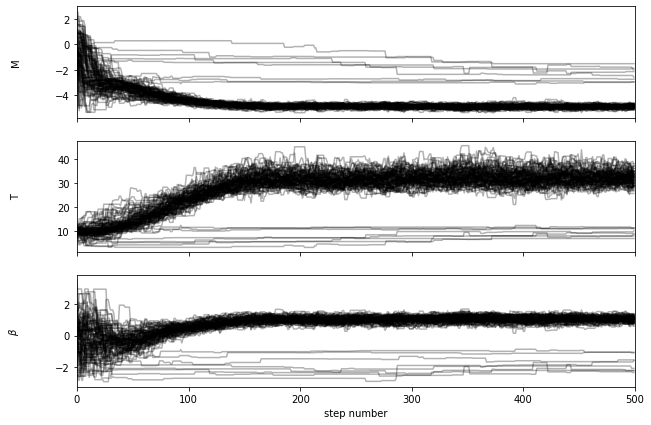

In [ ]:
#get the chains from the sampler
samples = sampler.get_chain()
flat_samples = sampler.get_chain(flat=True)

import matplotlib.pyplot as plt

#trace plots first

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
fig.patch.set_facecolor('white')
labels = ["M", "T", r"$\beta$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


We can also check the autocorrelation time (in terms of number of samples) for the chains. This gives us some idea of whether we have enough independent samples. 

In [ ]:
tau = sampler.get_autocorr_time(quiet=True)
print(tau)
taus = [tau]

N/50 = 10;
tau: [53.740919   60.21386764 52.32871848]


[53.740919   60.21386764 52.32871848]


But there are some caveats. For example, the autocorrelation time can appear short if we don't compute long enough MCMC chains to properly capture the autocorrelation behaviour

In [ ]:
#THIS STEP TAKES SOME TIME!

for i in range(9): #add more steps in chunks of 500 until we have 5000 steps, updating the autocorrelation time each 500 steps
  sampler.run_mcmc(sampler.get_last_sample(),steps)
  tau = sampler.get_autocorr_time(quiet=True)
  print(tau)
  taus.append(tau)
#sampler.run_mcmc(pos,steps*20)
#tau = sampler.get_autocorr_time()
#print(tau)

N/50 = 20;
tau: [77.82650339 87.49607554 74.17671962]


[77.82650339 87.49607554 74.17671962]


N/50 = 30;
tau: [ 88.73763569 100.18156755  84.53482057]


[ 88.73763569 100.18156755  84.53482057]


N/50 = 40;
tau: [100.90695924 111.56671025  97.01241239]


[100.90695924 111.56671025  97.01241239]


N/50 = 50;
tau: [109.37784564 120.66070582 105.40928281]


[109.37784564 120.66070582 105.40928281]


N/50 = 60;
tau: [112.56434392 122.54044816 107.50204054]


[112.56434392 122.54044816 107.50204054]


N/50 = 70;
tau: [113.75784858 120.41632901 108.24475886]


[113.75784858 120.41632901 108.24475886]


N/50 = 80;
tau: [116.38720756 122.05175838 110.86709607]


[116.38720756 122.05175838 110.86709607]


N/50 = 90;
tau: [117.5765648  122.10685881 111.74749679]


[117.5765648  122.10685881 111.74749679]


N/50 = 100;
tau: [117.33458206 120.09862047 110.69451591]


[117.33458206 120.09862047 110.69451591]


In [ ]:
#Optional code cell to keep computing a longer chain to see when we really have enough samples

for i in range(10): #add more steps in chunks of 500 until we have 10000 steps, updating the autocorrelation time each 500 steps
  sampler.run_mcmc(sampler.get_last_sample(),steps)
  tau = sampler.get_autocorr_time(quiet=True)
  print(tau)
  taus.append(tau)


N/50 = 110;
tau: [116.95557518 118.1088806  110.19448669]


[116.95557518 118.1088806  110.19448669]
[116.59460128 116.43830357 109.72712516]
[116.31429336 114.69615913 108.94802887]
[116.07312741 113.64818047 108.45818625]
[115.44338027 111.98932252 107.30522473]
[114.98110425 110.70432266 106.30264437]
[114.72915609 109.17832637 105.86950338]
[114.47772431 108.15902574 105.35521773]
[113.64458115 106.53438615 103.89148772]
[112.98210784 105.11702441 102.99900236]


Text(0.5, 0, 'Step')

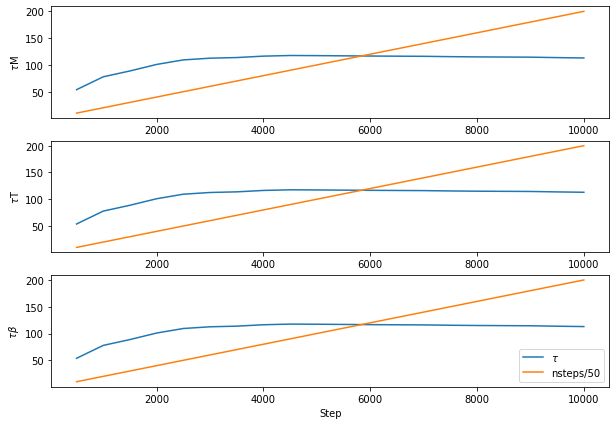

In [ ]:
taus = np.array(taus)
xs = (np.arange(20) + 1) * steps
figt, axest = plt.subplots(3, figsize =(10, 7), sharey = True)
figt.patch.set_facecolor('white')
for i in range(ndim):
  ax = axest[i]
  ax.plot(xs, taus[:,0], label=r"$\tau$")
  ax.plot(xs, xs/50, label="nsteps/50")
  ax.set_ylabel(r"$\tau$" + labels[i])
ax.legend(loc="lower right")
ax.set_xlabel("Step")

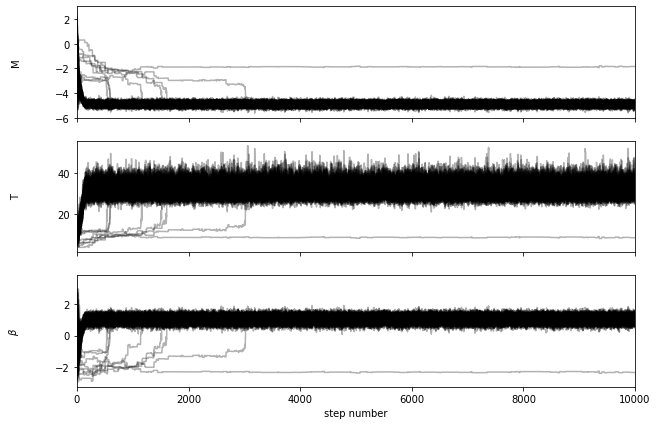

In [ ]:
samples = sampler.get_chain()

fig2, axes2 = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ["M", "T", r"$\beta$"]
for i in range(ndim):
    ax = axes2[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes2[-1].set_xlabel("step number");

If we trust these numbers, we can now discard the first chunk as burn in, and thin the chains to minimise correlation and flatten them (combine the chains from different walkers) for further analysis.

In [ ]:
flat_samples = sampler.get_chain(discard = 6000, thin = 90, flat = True)

Once we're sure we've computed enough samples we can check whether our model actually reproduces our data. We're Bayesians, so we don't have any sort of absolute measure of goodness of fit, only relative ones, so we can only do this through visualisation.

Hence, we use a technique called *posterior predictive checks*, whereby we draw samples from the posterior and evaluate the model and compare it to the data

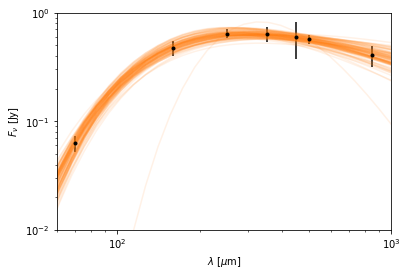

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="BlackBody provides the same capabilities")

inds = np.random.randint(len(flat_samples), size=100)
plot_x = np.logspace(np.log10(50), np.log10(1000), 30)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(plot_x, model(sample[0], sample[1], sample[2], plot_x), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.xlim(60, 1000)
plt.ylim(0.01, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\lambda$ [$\mu$m]")
plt.ylabel(r"$F_\nu$ [Jy]");

Now, we're sure that we have enough samples, that our model is representative of our data and we understand how big the impact of the choice of prior is, we can see what the posterior distributions of the model can tell us. The most straightfoward thing to do is to get point estimates and their credible intervals. These are determined from the 1D distribution of the posterior after marginalising out all other parameters, which is straightforward with MCMC samples:

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i]).replace("$", "")
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Another common tool is the *triangle plot* which shows the 2D marginal distributions of the parameters, which we can explore to see if parameters are correlated. 

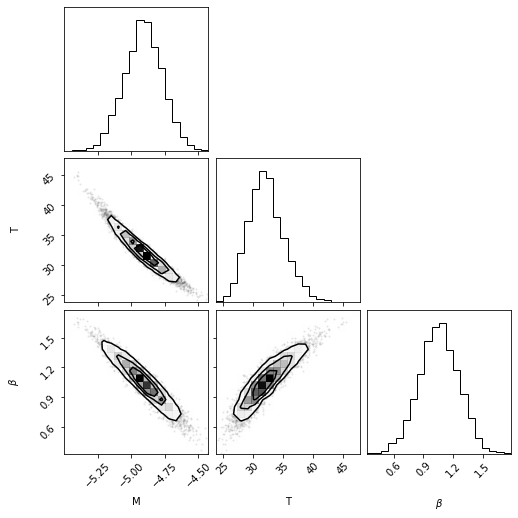

In [ ]:
try:
  import corner
except ImportError:
  !pip install corner
  import corner

#mask_samples = np.logical_and(flat_samples)
fig = corner.corner(
    flat_samples[flat_samples[:,2] > 0], labels=labels#, truths=[m_true, b_true, np.log(f_true)]
);
fig.patch.set_facecolor('white')

As we can see, all the parameters have correlations with the others. We can try to quantify some of those correlations by computing the numerical correlation matrix of the parameters, e.g.

In [ ]:
cov = np.cov(flat_samples, rowvar=False)
print(cov)

[[ 0.1113995  -1.13965963 -0.12872335]
 [-1.13965963 14.71723925  1.34179401]
 [-0.12872335  1.34179401  0.15304716]]


Which shows the large correlations between the parameters on the off-diagonal elements. However, this doesn't capture the whole picture, which is why the corner plot is useful. The correlation matrix can't tell us that the $T - \beta$ and $M - T$ correlations are non-Gaussian, but we can see that by eye from the banana-shaped contours.

We should also check that our choice of prior doesn't unnecessarily alter the results. This is known as *prior sensitivity testing*. Essentially, we must recompute the posterior to see what it would look like under the assumption of a different prior. Most of the time, this requires us to re-run the MCMC with the different prior. The code is included here to demonstrate (and provide a complete overview of the code in one place) but executing it is left as an exervise for the reader to compare the outputs.

In [ ]:
assert False #Ugly cludge to halt automatic execution when using Run all/ctrl+F9 to prevent next cell from executing.

N/50 = 10;
tau: [53.93095347 59.89693994 55.1752793 ]


[53.93095347 59.89693994 55.1752793 ]


N/50 = 20;
tau: [77.13991361 88.15160123 80.33237379]


[77.13991361 88.15160123 80.33237379]


N/50 = 30;
tau: [ 88.77278136 101.16666718  93.20304723]


[ 88.77278136 101.16666718  93.20304723]


N/50 = 40;
tau: [ 93.78253319 103.68951899  98.99468322]


[ 93.78253319 103.68951899  98.99468322]


N/50 = 50;
tau: [ 99.73767116 110.22727297 104.95262449]


[ 99.73767116 110.22727297 104.95262449]


N/50 = 60;
tau: [100.17486157 107.9926534  105.13326713]


[100.17486157 107.9926534  105.13326713]


N/50 = 70;
tau: [103.25924345 109.74936676 107.05659639]


[103.25924345 109.74936676 107.05659639]


N/50 = 80;
tau: [104.43787511 108.96077432 106.76371834]


[104.43787511 108.96077432 106.76371834]


N/50 = 90;
tau: [104.37422502 107.45812625 105.31688219]


[104.37422502 107.45812625 105.31688219]


N/50 = 100;
tau: [103.97769925 105.08424507 103.89204325]


[103.97769925 105.08424507 103.89204325]
[103.77940473 103.77867378 103.478454  ]
[102.96941703 101.64203097 101.76098557]
[102.68053555 100.85019211 101.33119794]
[102.53514987 100.25822262 100.88223736]
[102.29889788  99.15652803 100.31488088]
[101.74820943  98.03414973  98.86069028]
[100.91262556  96.16848623  97.49051524]
[100.16645466  94.75587766  96.48047567]
[99.79124359 93.54879268 95.56633627]
[99.15365375 92.32139947 94.66355422]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[[ 0.04560353 -0.65990983 -0.05259447]
 [-0.65990983 10.70103294  0.76761611]
 [-0.05259447  0.76761611  0.06534863]]


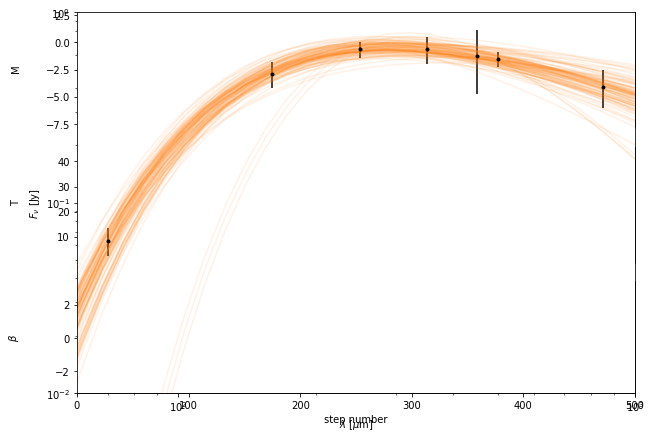

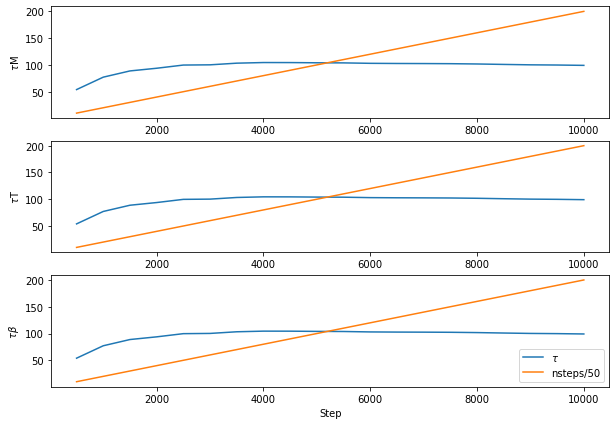

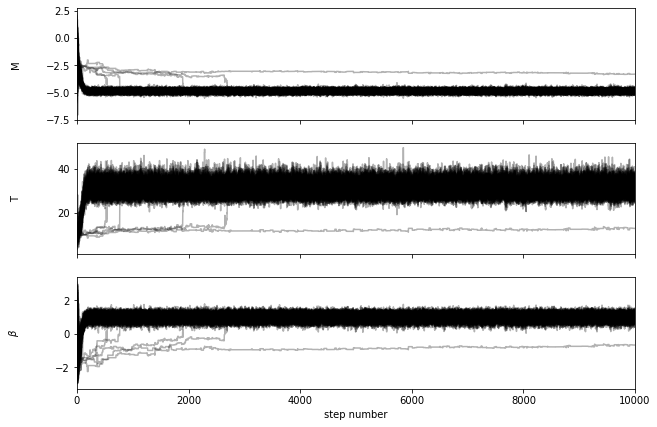

<Figure size 432x288 with 0 Axes>

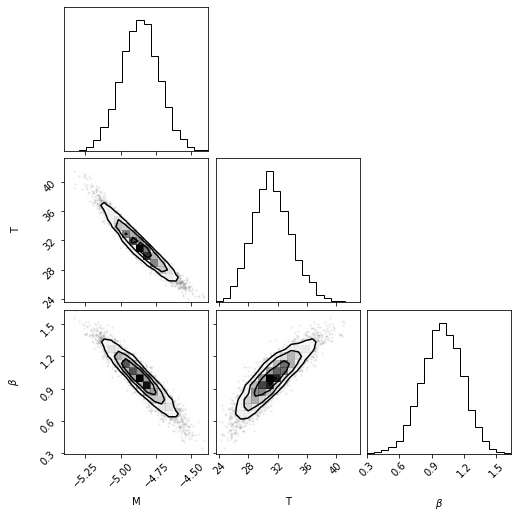

In [ ]:
import numpy as np #numpy is installed by default
#But you can also install packages that you need using pip
try:
  import emcee
except ImportError:
  !pip install emcee
  import emcee
try:
  from astropy import constants as const
except ImportError:
  !pip install astropy
  from astropy import constants as const
from astropy import units as u
from astropy.modeling import blackbody
try:
  import corner
except ImportError:
  !pip install corner
  import corner

import warnings
warnings.filterwarnings("ignore", message="BlackBody provides the same capabilities")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")

#Here's some data: These are observations of the flux of XXX from XXXXX
x = np.array([70., 160., 250., 350., 500., 450., 850.]) #Wavelengths in micron
y = np.array([0.06291731942186395, 0.4737297147415956, 
              0.6390202295454346, 0.6397258752453974, 
              0.5666783622052882, 0.5923100333782477, 
              0.4048189704746445])#np.array([10, 12, 9, 7, 4, 3, 1]) #Fluxes in Jy
yerr = np.array([0.010727567289237351, 0.07215265086492663, 
                 0.06050432065824665, 0.10415758267647844, 
                 0.052355096848173376, 0.21872154153894846, 
                 0.09148243225657898])#np.array([2, 2, 2, 2, 2, 2, 1]) #Uncertainties on the fluxes

normWave = 160. #wavelength (in micron) at which dust opacity is normalised
sigmaNormWave = 0.3 #opacity/mass-absorption coefficient of the dust at normWave
dist = 100*u.pc.to(u.m) #Distance to the star

def model(M, T, beta, lam):
  #convert lambda to nu
  freq = const.c.value / (lam*1e-6)

  bb = blackbody.blackbody_nu(freq,T).to(u.Jy / u.sr).value
  bb = bb / dist**2
  bb = bb * 10**(M)*const.M_sun.value * sigmaNormWave * ((lam / normWave)**beta)
  return bb

from scipy.stats import norm
def lnprior(theta):
  #This is our new prior - probability is limited to a given range where T is expected to be normally distributed, and zero outside
  if -10 < theta[0] < 10 and 3 < theta[1] < 100 and -3 < theta[2] < 3:
    return norm.logpdf(theta[1], 20, 10) #T prior has a mean of 20K with a standard deviation of 10K
  return -np.inf

def lnlike(theta, x, y, yerr):
  #This function calculates the likelihood P(D|M) for our model.
  M = theta[0]
  T = theta[1]
  beta = theta[2]
  flux = model(M, T, beta, x)
  return-0.5* np.sum((y - flux)**2 /yerr**2)

def lnprob(theta, x, y, yerr):
  lp = lnprior(theta)
  if lp == -np.inf:
    return lp
  return lp + lnlike(theta, x, y, yerr)

#Now we have a model, and we have defined our posterior, we can set up a sampler and get things moving.
ndim=3 #Three dimensions for this problem - M, T and beta
nwalkers=100 #emcee is an affine-invariant ensemble sampler. This means it uses several chains.
             # the number of walkers (=chains) must be even, and should be as large as possible (at least double ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

steps = 500
pos = [[0, 10, 0] + np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos,steps)

#get the chains from the sampler
samples = sampler.get_chain()
flat_samples = sampler.get_chain(flat=True)

import matplotlib.pyplot as plt

#trace plots first

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
fig.patch.set_facecolor('white')
labels = ["M", "T", r"$\beta$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

tau = sampler.get_autocorr_time(quiet=True)
print(tau)
taus = [tau]

#THIS STEP TAKES SOME TIME!

for i in range(9): #add more steps in chunks of 500 until we have 5000 steps, updating the autocorrelation time each 500 steps
  sampler.run_mcmc(sampler.get_last_sample(),steps)
  tau = sampler.get_autocorr_time(quiet=True)
  print(tau)
  taus.append(tau)

#Optional code cell to keep computing a longer chain to see when we really have enough samples

for i in range(10): #add more steps in chunks of 500 until we have 10000 steps, updating the autocorrelation time each 500 steps
  sampler.run_mcmc(sampler.get_last_sample(),steps)
  tau = sampler.get_autocorr_time(quiet=True)
  print(tau)
  taus.append(tau)

taus = np.array(taus)
xs = (np.arange(20) + 1) * steps
figt, axest = plt.subplots(3, figsize =(10, 7), sharey = True)
figt.patch.set_facecolor('white')
for i in range(ndim):
  ax = axest[i]
  ax.plot(xs, taus[:,0], label=r"$\tau$")
  ax.plot(xs, xs/50, label="nsteps/50")
  ax.set_ylabel(r"$\tau$" + labels[i])
ax.legend(loc="lower right")
ax.set_xlabel("Step")

samples = sampler.get_chain()

fig2, axes2 = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ["M", "T", r"$\beta$"]
for i in range(ndim):
    ax = axes2[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes2[-1].set_xlabel("step number");

flat_samples = sampler.get_chain(discard = 6000, thin = 90, flat = True)

import warnings
warnings.filterwarnings("ignore", message="BlackBody provides the same capabilities")

figpp = plt.figure()
axpp = fig.add_subplot(111)
inds = np.random.randint(len(flat_samples), size=100)
plot_x = np.logspace(np.log10(50), np.log10(1000), 30)
for ind in inds:
    sample = flat_samples[ind]
    axpp.plot(plot_x, model(sample[0], sample[1], sample[2], plot_x), "C1", alpha=0.1)
axpp.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
axpp.set_xlim(60, 1000)
axpp.set_ylim(0.01, 1)
axpp.set_xscale('log')
axpp.set_yscale('log')
axpp.set_xlabel(r"$\lambda$ [$\mu$m]")
axpp.set_ylabel(r"$F_\nu$ [Jy]");

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i]).replace("$", "")
    display(Math(txt))

#import corner

#mask_samples = np.logical_and(flat_samples)
fig = corner.corner(
    flat_samples[flat_samples[:,2] > 0], labels=labels#, truths=[m_true, b_true, np.log(f_true)]
);
fig.patch.set_facecolor('white')

cov = np.cov(flat_samples, rowvar=False)
print(cov)

# Some toy problems

Previous sections will have used some example problem (I'm thinking a modified blackbody, as it has some correlated parameters and is clearly astrophysically relevant) to demonstrate at each stage, building it up with emcee. Now I will basically demonstrate how to do the same thing with a few other packages.

# Problem set

## Fitting a line to data

First, we define a set of data that will be used in the first few problems here.

In [ ]:
x = np.array([ 0.23397176,  0.11288574,  0.50961469,  0.79911787,  0.52566214,
        1.50423103,  1.05759968,  1.93254129,  1.97368057,  2.46199348,
        2.8082922 ,  2.48448987,  3.18557041,  3.2426218 ,  3.07491281,
        3.97624142,  3.59475299,  4.52290351,  4.44632792,  4.9194819 ,
        3.43477682,  4.33252443,  5.53803749,  5.9694292 ,  6.96247836,
        5.87545248,  5.95249939,  7.55538808,  8.09503967,  5.57724702,
        8.25834164,  7.75371055,  8.57417011,  7.16522482,  8.76276191,
        8.25800109,  8.85517661, 10.62058448,  8.91969572,  8.21046701,
        9.05865873, 12.40087501,  9.86730305, 10.08400622, 10.96808943,
       11.3766884 , 14.01166776, 13.64927879, 12.91979521, 13.47962809])
xerr = np.array([0.39707461, 0.25286896, 0.40876382, 0.33422734, 0.44015499,
       0.23088603, 0.25107607, 0.39855484, 0.29186554, 0.55797678,
       0.12010648, 0.42387588, 0.12751993, 0.38407238, 0.51137741,
       0.17259736, 0.10992658, 0.12621551, 0.55812833, 0.10497772,
       0.32221105, 0.44205587, 0.55420819, 0.51460545, 0.21683453,
       0.29253898, 0.33786511, 0.42698222, 0.18027914, 0.1117489 ,
       0.10372124, 0.3186137 , 0.35795788, 0.46816197, 0.19754305,
       0.4101803 , 0.52614458, 0.31444343, 0.4971158 , 0.3011785 ,
       0.16670916, 0.58577319, 0.3536859 , 0.35960165, 0.37355915,
       0.34889201, 0.31134202, 0.36053818, 0.35934637, 0.59438089])
y = np.array([  5.33159863,   4.54207063,   3.94714832,   5.07835022,
         3.48107278,   5.75684067,   1.96142563,   5.37431185,
        -0.36494822,   2.10337149,   2.98365343,   0.78280289,
         3.13322895,   2.2306922 ,   1.07370918,   1.95343259,
         0.74043931,   1.00071999,   0.96095849,   0.9630811 ,
         1.16994485,   1.20598939,   0.09682621,   0.4290044 ,
        -0.57584825,  -0.53772109,   0.98842269,  -0.76816703,
        -0.49606409,  -0.60852032,  -1.82310651,  -1.69694637,
        -0.6495982 ,  -2.90039355,  -3.63629452,  -2.69475927,
        -3.88547614,  -4.95450567,  -4.08394741,  -3.75948239,
        -1.76474007,  -0.2151749 ,  -5.24217571,   0.47526216,
        -5.31799796,  -3.21582053, -12.99338521,  -7.43975556,
        -5.7743399 ,  -2.21306606])
yerr = np.array([0.42537167, 0.41059338, 0.48075352, 0.24533628, 0.13800163,
       0.22955306, 0.16164972, 0.43055699, 0.12072778, 0.3339441 ,
       0.51044773, 0.31123917, 0.47911244, 0.29986134, 0.46914146,
       0.31812468, 0.25274154, 0.39277097, 0.34739   , 0.45935337,
       0.32571458, 0.58467079, 0.15559012, 0.23166097, 0.35361529,
       0.17283631, 0.50050884, 0.59724943, 0.13159362, 0.38846466,
       0.5793877 , 0.17410052, 0.38810178, 0.30507875, 0.10496006,
       0.16885583, 0.38571698, 0.40130093, 0.54612869, 0.15087449,
       0.26459806, 0.22369835, 0.33098201, 0.47549512, 0.39043335,
       0.53012881, 0.19095729, 0.27526493, 0.22856709, 0.39380301])

This same dataset will be used for several different problems. First, assume that the uncertainty on x is negligible, but that the uncertainty on the y values has been underestimated by some amount. Try to infer both the slope and intercept of the line which generated this data, and the amount by which the uncertainty has been underestimated.

Next, take the uncertainties at face value, but try to modify the likelihood function to include uncertainties on both the x and y values. This problem is covered in detail by Hogg.

Now, a particularly common problem for astronomy. Let's say that the data are good, but the uncertainties reflect only the precision (that is, the statistical uncertainty on the measurement itself) but the values are drawn from some distribution where unknown variables perturb each source through physical mechanisms that are not included in our model. In this case, we say that the problem is affected by *intrinsic scatter*. Again, Hogg covers this in some detail, and it is widely applied to the M-sigma relation.

Finally, an advanced problem. What if the distribution of each measurement is *not* gaussian? Assume that the y values are **count rates** and try to re-write the likelihood function for this case.

## Checking convergence

The code cell below fits a model to some data - a spectrum interpreted with a single line. Make trace plots and calculate autocorrelation times for the chains and decide whether the MCMC has been run long enough yet. If not, how many steps does it need to run for?

In [ ]:
from scipy.stats import norm

x = np.array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96969697,
        7.07070707,  7.17171717,  7.27272727,  7.37373737,  7.47474747,
        7.57575758,  7.67676768,  7.77777778,  7.87878788,  7.97979798,
        8.08080808,  8.18181818,  8.28282828,  8.38383838,  8.48484848,
        8.58585859,  8.68686869,  8.78787879,  8.88888889,  8.98989899,
        9.09090909,  9.19191919,  9.29292929,  9.39393939,  9.49494949,
        9.5959596 ,  9.6969697 ,  9.7979798 ,  9.8989899 , 10.        ])
y = np.array([0.60614598, 0.6153662 , 0.47419432, 0.64142881, 0.5404495 ,
       0.65958241, 0.5388796 , 0.72837078, 0.56604171, 0.86397498,
       0.4751028 , 0.4119352 , 0.53598582, 1.04707218, 0.83268879,
       0.65939936, 0.71741511, 0.79977691, 0.76297566, 0.56573409,
       0.68881211, 0.93441395, 1.08102487, 1.06692672, 0.91861211,
       1.14857326, 0.98065209, 0.99522437, 0.98278417, 1.11751265,
       0.79828341, 0.18980406, 1.11795621, 1.16912414, 1.08937796,
       1.05315588, 0.95460981, 1.35636458, 1.5210485 , 1.70122012,
       1.8312029 , 2.50786172, 2.80173261, 3.10481785, 2.62385979,
       2.20492704, 1.6121115 , 1.64443925, 1.69162613, 0.96340852,
       0.86319356, 0.61203334, 0.87827908, 0.73654364, 0.99289407,
       0.74860198, 0.5520727 , 0.74797704, 0.60877654, 0.48734763,
       0.41548919, 0.47134843, 0.65060695, 0.55424859, 0.53872972,
       0.42004391, 0.50261679, 0.41800777, 0.14338189, 0.39985653,
       0.34840721, 0.37024026, 0.57578898, 0.16391488, 0.36135355,
       0.36556374, 0.72052741, 0.49379491, 0.58735107, 0.24443858,
       0.44170883, 0.498692  , 0.51745757, 0.45058975, 0.25297367,
       0.57483966, 0.29939929, 0.5941698 , 0.35649874, 0.56844186,
       0.45872986, 0.36447514, 0.52903476, 0.51461255, 0.70671988,
       0.36093269, 0.63303675, 0.76049668, 1.0671897 , 0.58650049])
yerr = np.array([0.13571468, 0.17649925, 0.2427158 , 0.19674616, 0.1374289 ,
       0.13734713, 0.23344185, 0.13494697, 0.16865474, 0.14877157,
       0.1523842 , 0.21276768, 0.21248585, 0.23104686, 0.2186303 ,
       0.16633297, 0.12466968, 0.19250511, 0.23896049, 0.24204692,
       0.11889055, 0.20328089, 0.19548629, 0.1582987 , 0.18590566,
       0.24759034, 0.23386036, 0.14216423, 0.18593009, 0.2357429 ,
       0.21747414, 0.24222248, 0.17103163, 0.1992606 , 0.15450062,
       0.22667307, 0.23436873, 0.11204839, 0.11259136, 0.11087712,
       0.23634978, 0.17765576, 0.24790074, 0.15669243, 0.1050639 ,
       0.11204431, 0.13651244, 0.14456857, 0.24083602, 0.21794055,
       0.18097375, 0.13599461, 0.23872987, 0.10324854, 0.24533545,
       0.12294229, 0.16149936, 0.10591347, 0.21025653, 0.18675912,
       0.16242686, 0.16716389, 0.18856679, 0.11728497, 0.11803215,
       0.15240304, 0.12481872, 0.17082965, 0.24074905, 0.13743163,
       0.23039399, 0.21941084, 0.24978922, 0.19685753, 0.16923487,
       0.22468505, 0.18220194, 0.10126559, 0.16738149, 0.13034307,
       0.16072441, 0.12061447, 0.15581466, 0.18634505, 0.21928294,
       0.12790317, 0.21768046, 0.15576875, 0.19392913, 0.10682687,
       0.18502616, 0.17874781, 0.1710912 , 0.12937686, 0.20394657,
       0.13313035, 0.10067853, 0.24100547, 0.18669291, 0.19211422])


def model(x, centre, width, int_intens, baseline):
  #A model for a spectral line described by a gaussian, normalised by integrated intensity
  return int_intens*norm.pdf(x, centre, width) + baseline

def lnlike(theta, x, y, yerr):
  #This function calculates the likelihood P(D|M) for our model.
  centre = theta[0]
  width = theta[1]
  int_intens = theta[2]
  baseline = theta[3]
  flux = model(x, centre, width, int_intens, baseline)
  return-0.5* np.sum((y - flux)**2 /yerr**2)

def lnprior(theta):
  #This is a flat prior - probability is uniform inside a given range, and zero outside
  if -10 < theta[0] < 10 and 0 < theta[1] < 100 and 0 < theta[2] < 3 and -10 < theta[3] < 10:
    return 0
  return -np.inf

def lnprob(theta, x, y, yerr):
  lp = lnprior(theta)
  if lp == -np.inf:
    return lp
  return lp + lnlike(theta, x, y, yerr)


ndim=4 #Three dimensions for this problem - M, T and beta
nwalkers=100 #emcee is an affine-invariant ensemble sampler. This means it uses several chains.
             # the number of walkers (=chains) must be even, and should be as large as possible (at least double ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

steps = 500
pos = [[0, 1, 0, 0] + np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos,steps)

State([[ 4.30698245  0.37538387  1.99589112  0.60391623]
 [ 4.31029293  0.38675313  1.89884259  0.63245835]
 [ 4.29232002  0.32888891  1.86545952  0.65168914]
 [ 4.30123308  0.35909561  1.90436449  0.62064179]
 [ 4.30065495  0.35226575  1.88529494  0.59876063]
 [-7.77848653  1.15068747  0.11697991  0.86299199]
 [-1.01280783 -0.36686548 -2.19605223 -1.67595619]
 [ 4.27774108  0.33427478  1.93173168  0.603249  ]
 [ 4.30487786  0.36094901  1.90813135  0.60820885]
 [ 4.32900258  0.37325395  1.92563384  0.60026777]
 [-8.45164511  2.12173945  0.24681781  0.88323435]
 [ 4.29269656  0.36917022  1.85076217  0.60490078]
 [-5.03834859  1.75107521  1.52811445  0.85003628]
 [-7.79698775  4.45435657  1.93654094  0.83454301]
 [ 4.29656179  0.35108297  1.9661742   0.62807585]
 [ 4.29019574  0.36961875  1.84688643  0.60476372]
 [ 4.29033493  0.36642923  1.93626287  0.59556982]
 [ 4.28357678  0.36545818  1.8882496   0.62014856]
 [ 4.30431314  0.36706437  1.7453771   0.62740972]
 [-6.88067363  1.26205111

In [ ]:
#Put your work here

## Posterior predictive checks

Using the example from the previous section, is the model appropriate for the data?

## Prior sensitivity tests

Try varying the prior of the above model and see what difference  this makes to the fit. First, try changing the bounds of the flat prior. Then see if you can estimate any of the parameters ahead of time to impose non-flat priors on the parameters.

## Nuisance parameters

Go back to the modified blackbody example given above. In that case we assumed that the distance is a delta function (known exactly). In most cases, however, we have a measured distance with an uncertainty, possibly from parallax measurements. Attempt to re-write this example to assume that the distance can be constrained by a parallax of 10 +/- 1 milliarcseconds, and marginalise out this constraint to see what effect this has on the posterior distribution of the mass.

## Using other packages

Now try to repeat some of the examples using other MCMC packages. In particular, if you used a black box code before, try probabilistic programming instead, or vice versa. 

In [ ]:
""" Copyright 2021 Peter Scicluna

Permission is hereby granted, free of charge, to any person obtaining a copy of 
this software and associated documentation files (the "Software"), to deal in 
the Software without restriction, including without limitation the rights to 
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of 
the Software, and to permit persons to whom the Software is furnished to do so, 
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all 
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR 
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS 
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR 
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER 
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE."""